# Ball And Stick3

In [1]:
from neuron import h, gui
from neuron.units import ms, mV
h.load_file('stdrun.hoc')

1.0

In [2]:
"""
각 셀이 스파이크 시간, 막전위 시간대를 기록하도록 하고 Netcon을 추적하도록 한다.
"""
class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x, y, z)
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        self._ncs = []
        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)

    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid)
    
    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i, x - self.x + sec.x3d(i), y - self.y + sec.y3d(i), z - self.z + sec.z3d(i), sec.diam3d(i))
        self.x, self.y, self.z = x, y, z
        
    def _rotate_z(self, theta):
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

In [3]:
class BallAndStick(Cell):
    name = 'BallAndStick'
    
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        self.dend.insert('pas')                 
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65    # Leak reversal potential mV
        self.syn = h.ExpSyn(self.dend(0.5))
        self.syn.tau = 2 * ms
        # input이 .syn이라는 한 지역을 통해 입력 되는 것으로 간주시킴.
"""
h.ExpSyn decay에 의해 두 개의 ExpSyn object가 같은 point에 있는 것이나 
linearly하게 더해지는 서로 다른 두 synapse가 한 군데에 input하는 것과 다름이 없다.
이 point를 dend(0.5)로 정하자.
"""
pass

In [4]:
"""
Ring Class

N개의 ball-and-stick cell들이 n->n+1로의 excitatory synapse를 가지고 있는 network.
Nth cell은 1번째 cell을 project한다.
"""
class Ring:
    def __init__(self, N=5, stim_w=0.04, stim_t=9, stim_delay=1, syn_w=0.01, syn_delay=5, r=50):
        self._syn_w = syn_w  #Stimulus weight
        self._syn_delay = syn_delay
        self._create_cells(N, r)
        self._connect_cells()
        self._netstim = h.NetStim()
        self._netstim.number = 1
        self._netstim.start = stim_t
        self._nc = h.NetCon(self._netstim, self.cells[0].syn)
        self._nc.delay = stim_delay
        self._nc.weight[0] = stim_w
        
    def _create_cells(self, N, r):
        self.cells = []
        for i in range(N):
            theta = i * 2 * h.PI / N
            self.cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
    """
    Ball And Stick #2의 create_n_BallAndStick 함수와 같은 방식으로 세포를 선언/배치.
    단, 세포들이 return되는 create_n_BallAndStick과 달리 self.cells에 저장됨.
    """
    def _connect_cells(self):
        for source, target in zip(self.cells, self.cells[1:] + [self.cells[0]]):
            nc = h.NetCon(source.soma(0.5)._ref_v, target.syn, sec=source.soma)
            nc.weight[0] = self._syn_w
            nc.delay = self._syn_delay
            source._ncs.append(nc)

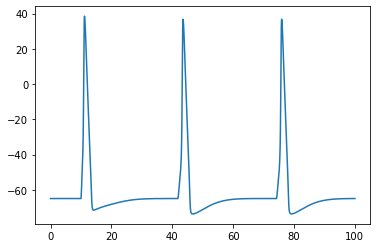

In [5]:
ring = Ring(N=5)

t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(100)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(t, ring.cells[0].soma_v)
plt.show()

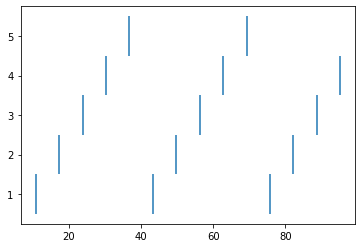

In [6]:
plt.figure()
for i, cell in enumerate(ring.cells):
    plt.vlines(cell.spike_times, i + 0.5, i + 1.5)
    """
    enumerate function : ring.cells의 element와 index를 튜플 형태로 처리시킨다.
    이를 for문에 i, cell의 형태로 unpacking하여 index를 graph에 plotting하는 데에 쓴 모양.
    plt.vlines(a, b, c) x=a에 y=[b, c]의 vertical line을 세움.
    """
plt.show()

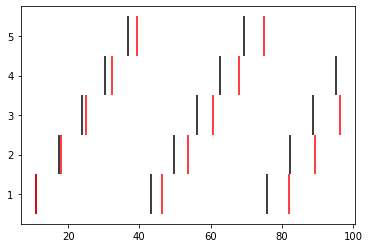

In [7]:
"""
synapse weight를 조정하였을 때, spiking에는 어떤 양상을 보이는가?
"""
plt.figure()
for syn_w, color in [(0.01, 'black'), (0.005, 'red')]:
    ring = Ring(N=5, syn_w=syn_w)
    h.finitialize(-65 * mV)
    h.continuerun(100 * ms)
    for i, cell in enumerate(ring.cells):
        plt.vlines(cell.spike_times, i + 0.5, i + 1.5, color=color)

plt.show()
"""
서로 다른 weight=0.01, 0.005에 대하여 각각 stimulation을 제공한 후, vertical line을 plot해보면
weight가 낮은 0.005의 case에서 꾸준히 증가하는 delay가 관찰되었다.
"""
pass